In [1]:
# Imports
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '3'

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore', category=Warning)



import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import plotly.graph_objects as go

from tensorflow.python.client import device_lib
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
n_prediction_days = 30
time_window = 60

In [3]:
symbol = 'AAPL'
ticker = yf.Ticker(symbol)
data = ticker.history(period='1y')
data = data.filter(['Close'])

In [4]:
# prepare the data
df = data.copy()
hidden = df.loc[df.index[-n_prediction_days]:]
hidden.to_csv('hidden.csv')

# delete the var hidden
del hidden

df = df.loc[:df.index[-n_prediction_days-1]]

In [5]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

In [6]:
# prepare train data
X_train, y_train = [], []
for i in range(60, scaled_data.shape[0]):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
# build model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [8]:
# compile & fit model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=128, verbose=0);

In [9]:
# predict future
for i in range(n_prediction_days):
    future = df[-time_window:][['Close']].copy()
    future = scaler.transform(future)

    X_future = []
    X_future.append(future)
    X_future = np.array(X_future)
    X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

    predicted = model.predict(X_future, verbose=0)
    predicted = scaler.inverse_transform(predicted)

    idx = [df.index[-1] + pd.Timedelta(days=1)]
    row = pd.DataFrame({'Close':predicted[0]}, index=idx)
    df = pd.concat([df, row])

In [10]:
# reload hidden and merge it into df
merged = df.copy()
merged['Predicted'] = np.nan
merged['Predicted'][-n_prediction_days:] = merged['Close'][-n_prediction_days:]
merged['Close'][-n_prediction_days:] = np.nan

hidden = pd.read_csv('hidden.csv', index_col=0)
hidden.index = pd.to_datetime(hidden.index)
hidden.rename(columns={'Close':'Hidden'}, inplace=True)
merged = pd.merge(merged, hidden, how='left', left_index=True, right_index=True)
merged.tail(40)

,Close,Predicted,Hidden
2023-12-28 05:00:00+00:00,193.333298,NaN,NaN
2023-12-29 05:00:00+00:00,192.284637,NaN,NaN
2024-01-02 05:00:00+00:00,185.403412,NaN,NaN
2024-01-03 05:00:00+00:00,184.015198,NaN,NaN
2024-01-04 05:00:00+00:00,181.678177,NaN,NaN
2024-01-05 05:00:00+00:00,180.949097,NaN,NaN
2024-01-08 05:00:00+00:00,185.323517,NaN,NaN
2024-01-09 05:00:00+00:00,184.904053,NaN,NaN
2024-01-10 05:00:00+00:00,185.952713,NaN,NaN
2024-01-11 05:00:00+00:00,185.353485,NaN,NaN


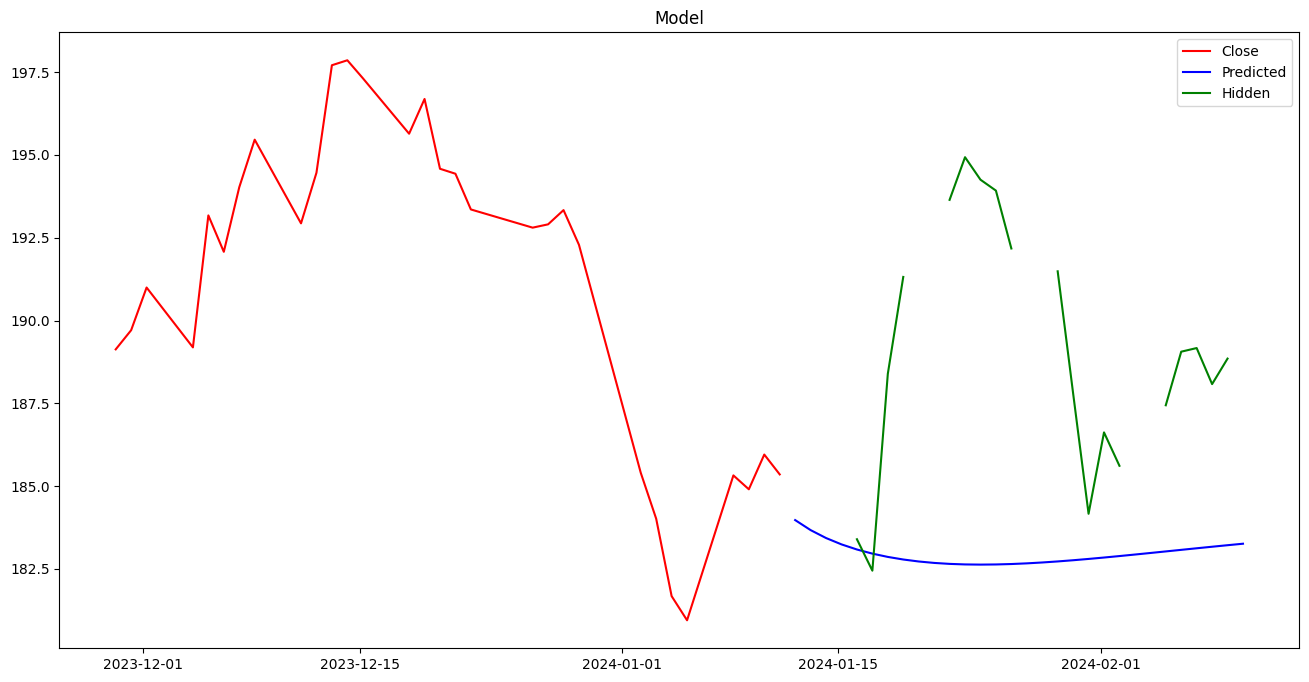

In [11]:
# plot the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.plot(merged['Close'][-time_window:], color='r')
plt.plot(merged['Predicted'][-time_window:], color='b')
plt.plot(merged['Hidden'][-time_window:], color='g')
plt.legend(['Close', 'Predicted', 'Hidden'])
plt.show()